<a href="https://colab.research.google.com/github/drewwint/Learning/blob/main/HGF_Filter_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(theory)=
# Introduction to the Generalised Hierarchical Gaussian Filter

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/0.1-Theory.ipynb)

The Hierarchical Gaussian Filter is a Bayesian model of belief updating under uncertainty in which the volatility of the environment is encoded by a hierarchy of probability distributions. A generalised version of this model {cite:p}`weber:2023` has further framed this into a neural network framework of probabilistic state nodes interacting with each other. At the heart of both frameworks lies a generative model that consist in a hierarchy of {term}`Gaussian Random Walk`. The inversion of this model (i.e. estimating parameters from observed values) leads to the derivation of prediction errors and posterior updates that can turn these networks into learning systems. To fully understand this model, it is therefore central to start with the simplest case, the implied generative model, which can be seen as the probabilistic structure that generates observations.

In this notebook, we introduce the main concepts on which the Hierarchical Gaussian Filter (HGF) is based. We review equations of the generative model and illustrate them through examples only using [Numpy](https://numpy.org/). Later in the theory section, we will discuss how this generative model can be turned into a network of probabilistic nodes, and how this framework can generalize to the whole exponential distribution family.

In [ ]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install watermark

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams["figure.constrained_layout.use"] = True

## The generative model

### Gaussian Random Walks
To illustrate the generative model on which the HGF is based, we will start with a simple  two-level continuous HGF (see also the tutorial {ref}`continuous_hgf`). The generative model that underpins the continuous HGF is a generalisation of the [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRW). A GRW generate a new observation $x_1^{(k)}$ at each time step $k$ from a normal distribution and using the previous observation $x_1^{(k-1)}$ such as:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \sigma^2)
$$

where $\sigma^2$ is the variance of the distribution.

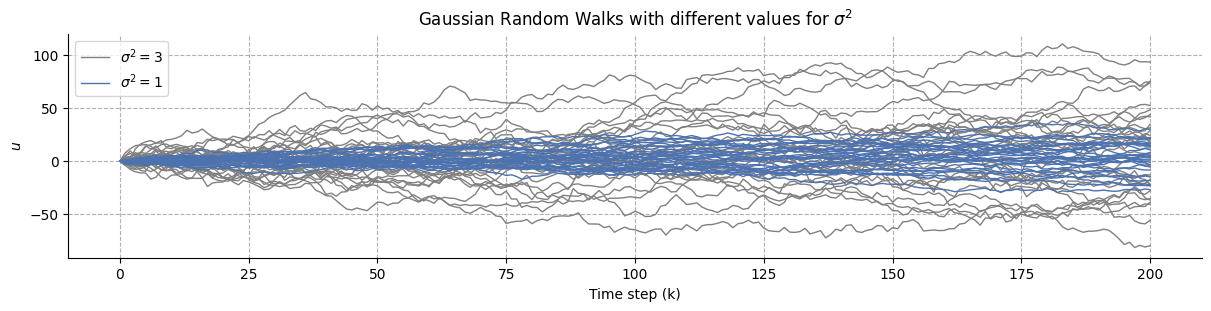

In [ ]:
np.random.seed(123)

# Simpulate two sets of Gaussian Random Walks
u_1 = np.insert(np.cumsum(np.random.normal(
    loc=0, ## average is 0
    scale=1, ## variance is 1
    size=(30, 200)
    ), axis=1), 0, 0, axis=1)

u_2 = np.insert(np.cumsum(
    np.random.normal(
        loc=0, ## average 0
        scale=3, ## variance is 3
        size=(30, 200)), axis=1), 0, 0, axis=1)

_, ax = plt.subplots(figsize=(12, 3))
ax.plot(u_2.T, linewidth=1, color="grey", label=r"$\sigma^2 = 3$")
ax.plot(u_1.T, linewidth=1, color="#4c72b0", label=r"$\sigma^2 = 1$")
ax.set(xlabel="Time step (k)", ylabel="$u$", title=r"Gaussian Random Walks with different values for $\sigma^2$")
ax.grid(linestyle="--")
ax.legend()

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique))
sns.despine()

This simple process will be our first building block. Importantly here, the variability of the sensory input is constant across time: even if we don't know exactly in which direction the time series is going to move in the future, we know that it is unlikely to make certain kinds of big jumps because it is controlled by a fixed parameter, the variance $\sigma^2$.

#### Adding a drift to the random walk

The Gaussian random walk can be further parametrized by adding a drift over time. This value, often noted $\rho$, will be added at each time step:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)} + \rho, \sigma^2)
$$

We run the same simulation using $\rho = 0.1$ in the cell below:

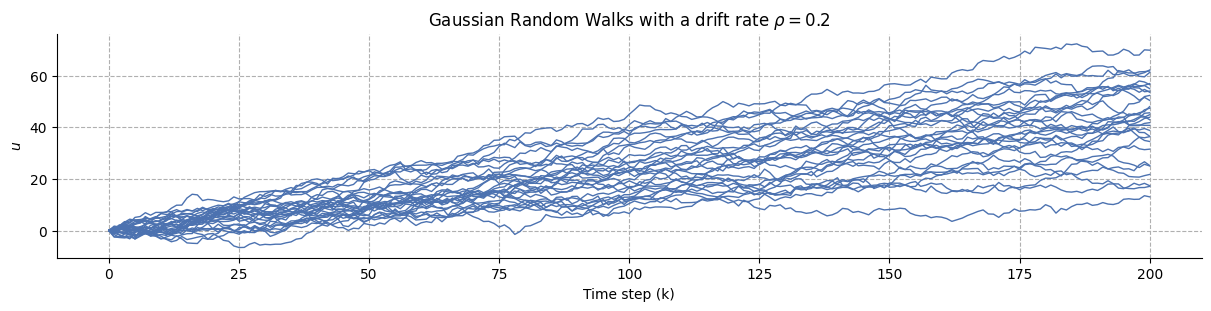

In [ ]:
np.random.seed(123)

# add a drift at each time step
rho = .2 ## rho (p) for drift

# random walk
u_1 = np.insert(
    np.cumsum(
        np.random.normal(
            loc=rho, ## the next step has a random drift with row
            scale=1,
            size=(30, 200)
            ),
        axis=1),
    0,
    0,
    axis=1)

_, ax = plt.subplots(figsize=(12, 3))
ax.plot(u_1.T, linewidth=1, color="#4c72b0")
ax.set(xlabel="Time step (k)", ylabel="$u$", title=r"Gaussian Random Walks with a drift rate $\rho = 0.2$")
ax.grid(linestyle="--")
sns.despine()

#### Autoregressive processes

We can also assume that the generative process follows an [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model), in which case the value of the next iteration is weighted by a coefficient and pointing to an intercept, often noted $\phi$ and $m$ (respectively) in the Matlab toolbox.


$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)} + \phi(m - x_1^{(k-1)}), \sigma^2)
$$

We repeat the same simulation below using $\phi = .4$ and $m = 12.0$.

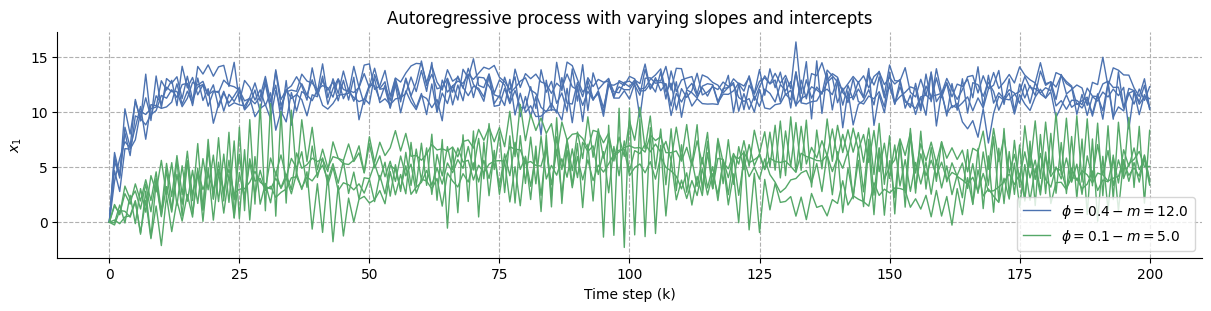

In [ ]:
np.random.seed(123)

# random walk with AR1 process
_, ax = plt.subplots(figsize=(12, 3))

## first with 0.4 and 12
phi, m = 0.4, 12.0
for i in range(5):
    x_1 = [0.0] # starts at 0 (so when i-1 we start with 0)
    for i in range(200):
        x_1.append(np.random.normal(
            x_1[i - 1] + # prior timepoint
            phi * # plus the coeffieient here it is 0.4
             (m - x_1[i - 1] ## multiplied by the intercept (here 12) minus the previous timepoint value
              ),
            scale=1)) # variance of 1
    ax.plot(x_1, color="#4c72b0", label=r"$\phi = 0.4 - m = 12.0$", linewidth=1)
  ## because we are having the prior timepoint inform the next step (mean) it is autoregressive

## second with 0.1 and 5
phi, m = 0.1, 5.0
for i in range(5):
    x_1 = [0.0]
    for i in range(200):
        x_1.append(np.random.normal(x_1[i - 1] + phi * (m - x_1[i - 1]), scale=1))
    ax.plot(x_1, color="#55a868", label=r"$\phi = 0.1 - m = 5.0$", linewidth=1)


ax.set(xlabel="Time step (k)", ylabel="$x_{1}$", title="Autoregressive process with varying slopes and intercepts")
ax.grid(linestyle="--")

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique))
sns.despine()

With the two examples above, we have seen that a {term}`Gaussian Random Walk` - the simple iterative sampling from a given Gaussian distribution at each time step - can be further influenced by two kinds of parameterizations:
1. by adding a constant drift.
2. by adding an autoregressive component, with a slope and intercept.

The main idea behind the generative model of the Hierarchical Gaussian filter is that variables that *complexify* a regular {term}`Gaussian Random Walk` are controlled by a hierarchy of other nodes, where each {term}`Node` is also a {term}`Gaussian Random Walk`. This remote influence can come in two ways:
1. through **value coupling**, a parent node can influence the mean of the {term}`Gaussian Random Walk` of its child.
2. through **volatility coupling**, a parent node can influence the variance of the {term}`Gaussian Random Walk` of its child.

In the next sections, we simulate different kinds of couplings between two {term}`Gaussian Random Walk`.

### Value coupling

We call value coupling the influence that a parent node, or a group of parent nodes, exert on the mean of the {term}`Gaussian Random Walk` of a child node. In that case, the mean of the Gaussian random walk at one level is a function not only of its previous value but also the current value of the higher-level state. Such a model can be formalized as follows:

$$
\begin{align*}
    x_1^{(k)} & \sim \mathcal{N}(\lambda_1 x_1^{(k-1)} + \rho_1 + f(x_2^{(k)}), \, \sigma_1^2) \\
    x_2^{(k)} & \sim \mathcal{N}(x_2^{(k-1)}, \, \sigma_2^2)
\end{align*}
$$

where the parent node $x_2$ exerts an influence on the mean of the child node $x_1$. We can see that some variables have been introduced here, namely $\lambda_1$, the autoconnection strength (i.e. the strength of the influence of the mean from the previous time step) and $\rho_1$, the tonic drift (i.e. the propensity for the {term}`Gaussian Random Walk` to naturally drift in some direction). This simple equation turns out to be a very efficient way to combine drift rates and autoregressive processes while being controllable through a unique parameter ($\lambda_1 \in [0, 1]$). With $lambda_a = 1$, the node is performing a Gaussian Random Walk and the drift rate is some of the tonic and phasic drift. When $\lambda_1 < 1$, the node follows an autoregressive process and reverts back to the total mean $M_1$, given by:
$$
    M_1 = \frac{\rho_1 + f\left(x_2^{(k)}\right)} {1-\lambda_1},
$$

If $\lambda_a = 0$, the node is not influenced by its own mean anymore, but only by the value received from the value parent. More details can be found in {cite:p}`weber:2023`.

In [ ]:
np.random.seed(123)

lambda_1, lambda_2, lambda_3 = 0.0, .9, 1.0
rho = 0.0
sigma_1 = 1.0
mu_1, mu_2 = 0.0, 0.0

# lambda = 0.0
x_2_1 = np.repeat([0, 1, 0, -2], 250) * 3 ## specifying the mu2 values across the timeseries
x_1_1 = [] # initiating the list for mu1 values
for mu_2 in x_2_1: ## looping over the mu2 values at each step
    mu_1 = np.random.normal(
        lambda_1 * mu_1 + rho + mu_2, sigma_1
        ## just like the first equation for x1
          ## the value of x1(k) is distributed by
          ## lambda * x1(k-1) + rho + mu2(k) at currnet step
          ## given that mu1 is calculated at each step (see mu_1 =...)
            ### this means we are getting the prior timepoint of mu1
        )
    x_1_1.append(mu_1)

# lambda = 0.9
mu_1, mu_2 = 0.0, 0.0
x_2_2 = np.tile(np.repeat([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 10) * 6, 10)
x_1_2 = []
for mu_2 in x_2_2:
    mu_1 = np.random.normal(lambda_2 * mu_1 + rho + mu_2, sigma_1)
    x_1_2.append(mu_1)

# lambda = 1.0
mu_1, mu_2 = 0.0, 0.0
x_2_3 = np.tile(np.repeat([0, 1, 0, -2], 125) * .5, 2)
x_1_3 = []
for mu_2 in x_2_3:
    mu_1 = np.random.normal(lambda_3 * mu_1 + rho + mu_2, sigma_1)
    x_1_3.append(mu_1)

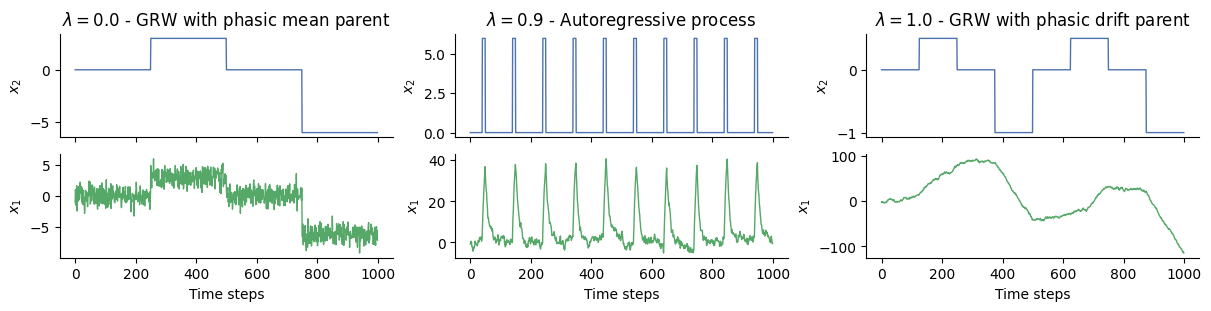

In [ ]:
_, axs = plt.subplots(figsize=(12, 3), nrows=2, ncols=3, sharex=True)

# lambda = 0.0
axs[0, 0].plot(x_2_1, "-", linewidth=1, color="#4c72b0")
axs[0, 0].set(title=r"$\lambda=0.0$ - GRW with phasic mean parent", ylabel=r"$x_2$")

axs[1, 0].plot(x_1_1, "-", linewidth=1, color="#55a868")
axs[1, 0].set(xlabel="Time steps", ylabel=r"$x_1$")

# lambda = 0.9
axs[0, 1].plot(x_2_2, "-", linewidth=1, color="#4c72b0")
axs[0, 1].set(title=r"$\lambda=0.9$ - Autoregressive process", ylabel=r"$x_2$")

axs[1, 1].plot(x_1_2, "-", linewidth=1, color="#55a868")
axs[1, 1].set(xlabel="Time steps", ylabel=r"$x_1$")

axs[0, 2].plot(x_2_3, "-", linewidth=1, color="#4c72b0")
axs[0, 2].set(title=r"$\lambda=1.0$ - GRW with phasic drift parent", ylabel=r"$x_2$")

axs[1, 2].plot(x_1_3, "-", linewidth=1, color="#55a868")
axs[1, 2].set(xlabel="Time steps", ylabel=r"$x_1$")
sns.despine()

### Volatility coupling
Now, we can also decide to change that and let the variance itself be a stochastic process generated by another random walk. The HGF fundamentally capitalise on this notion and generalizes the standard GRW by letting the variance $\sigma^2$ be controlled by a higher-level node.

If we take as example the two-level continuous HGF {cite:p}`2014:mathys`, the model is constituded of two states of interest, $x_1$ and $x_2$. $x_1$ is performing a GRW as previously defined, but it is also paired with $x_2$ to each other via *volatility coupling*. This means that for state $x_1$, the mean of the Gaussian random walk on trial $k$ is given by its previous value $x_1^{(k-1)}$, while the step size (or variance) depends on the current value of the higher level state, $x_2^{(k)}$.

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \, f(x_2^{(k)}))
$$

where the exact dependency is of the form

$$
    f(x_2^{(k)}) = \exp(\kappa_1 x_2^{(k)} + \omega_1)
$$

with $\kappa$ as scalling parameter (by defaults in most case it is set to `1` which indicates a complete volatility coupling), and $\omega_1$ being the *evolution rate*, also refered as the tonic part of the variance, the part that is not inherited from parent nodes.

At the higher level of the hierarchy (here the second level), the nodes are not inheriting anything from their parents anymore, and only rely on their own variance:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k-1)}, \, \exp(\omega_2))
$$

The model described above can be implemented in Python as the following:

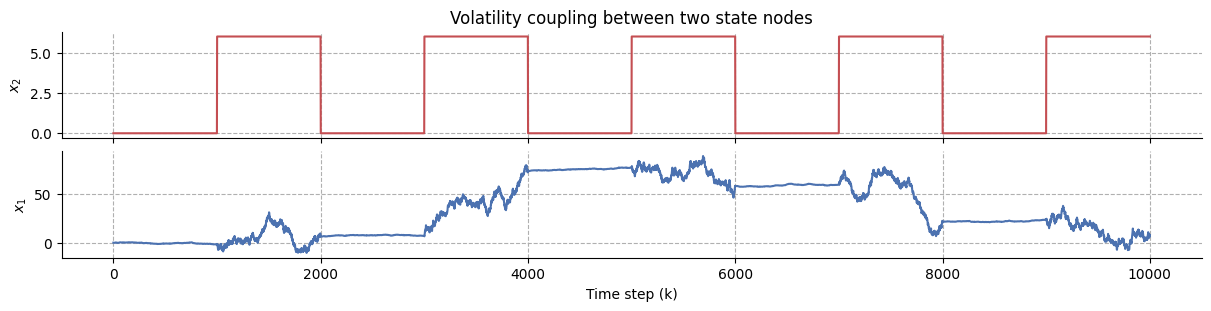

In [ ]:
np.random.seed(123)

kappa_1 = 1.0
omega_1, omega_2 = -6.0, -6.0
mu_1, mu_2 = 0.0, -2.0
x_1 = [0]

# x2 - volatility parent
x_2 = np.tile(np.repeat([0, 1], 1000), 5) * 6

# A Gaussian Random Walk with a volatility parent
for i in range(10000):

    mu_2 = x_2[i]

    # x1 - child node
    pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
    mu_1 = np.random.normal(mu_1, pi_1**0.5)

    x_1.append(mu_1)

_, axs = plt.subplots(figsize=(12, 3), nrows=2, sharex=True)
axs[0].plot(x_2, "-", color="#c44e52")
axs[1].plot(x_1, "-", color="#4c72b0")
axs[0].set(ylabel="$x_{2}$", title="Volatility coupling between two state nodes")
axs[1].set(xlabel="Time step (k)", ylabel="$x_{1}$")

axs[0].grid(linestyle="--")
axs[1].grid(linestyle="--")
sns.despine()

In this example, it becomes apparent that the volatility of the observation is not constant in time anymore, but depends on the values observed at the level above.

## Dynamic beliefs updating
### The Hierarchical Gaussian Filter in a network of predictive nodes
The coding examples introduced above illustrated generative models that can simulate data forward from a given volatility structure, with key parameters stochastically fluctuating. Based on these principles, any given latent state in the world can be modelled as having a volatility parent state, a value parent state, both, or none. When the node is an orphan, it evolves as a Gaussian random walk around its previous value with a fixed step size. Consequently, when inferring the evolution of these states, the exact belief update equations (which include the computation of new predictions, posterior values, and prediction errors, and represent an approximate inversion of this generative model, see {cite:p}`2011:mathys` depend on the nature of the coupling of a given state with its parent and children states. In particular, the nodes that implement the belief updates will communicate with their value parents via value prediction errors, or **VAPE**s, and volatility prediction errors, or **VOPE**s, with their volatility parents. Hierarchical Gaussian Filters use this as a model of the environment to make sense of new observations, also referred to as the sensory part of the HGF, or the filtering part. In this situation, new observations are coming in at the network's root and the model updates the belief structure accordingly (from bottom to top nodes). It is therefore straightforward to describe the standard two-level and three-level Hierarchical Gaussian Filters for continuous and binary inputs as the combination of value and volatility couplings (see {ref}`hgf-fig`)

```{figure} ../images/hgf.svg
---
name: hgf-fig
---
The two-level and three-level Hierarchical Gaussian Filters for binary or continuous inputs.

These models were described in {cite:p}`2014:mathys,2011:mathys`. The binary HGF has the particularity that it uses a sigmoid transform in the input node to convert continuous values into binary probabilities. For both models, volatility coupling is depicted with dashed lines, and value coupling with straight lines. The three-level HGF has one volatility layer more than the two-level HGF, which is used to estimate higher-order uncertainty.
```

```{hint}
Hierarchical Gaussian Filters are inspired by other simpler models for Bayesian filtering and reinforcement learning. These models can be seen for example as generalisation of the [Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter) or the [Rescorla-Wagner model](https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model). Specifically:

* A one-level HGF for continuous input can be seen as a [Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter).
* A two-level binary HGF can be seen as a [Rescorla-Wagner](https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model) model with an adaptive learning rate that depends on the precision of the belief.
```

### The propagation of prediction and prediction errors

Having described the model as a specific configuration of predictive nodes offer many advantages, especially in term of modularity for the user. However, the model itself is not limited to the description of the generative process that we covered in the previous examples. The most interesting, and also the more complex, part of the modelling consists of the capability for the network to update the hierarchical structure in a Bayesian optimal way as new observations are presented. These steps are defined by a set of simple, one-step update equations that represent changes in beliefs about the hidden states (i.e. the sufficient statistics of the nodes) specified in the generative model. These equations were first described in {cite:t}`2011:mathys`, and the update equations for volatility and value coupling in the generalized Hierarchical Gaussian filter (on which most of the update functions in [pyhgf](https://github.com/ComputationalPsychiatry/pyhgf) are based) have been described in {cite:p}`weber:2023`. The exact computations in each step especially depend on the nature of the coupling (via {term}`VAPE`s vs. {term}`VOPE`s) between the parent and children nodes. It is beyond the scope of this tutorial to dive into the derivation of these steps and we refer the interested reader to the mentioned papers. Here, we provide a general overview of the dynamic of the update sequence that supports belief updating. The computations triggered by any observation at each time point can be ordered in time as shown in the belief update algorithm.

```{note} Belief update
:name: belief-update

Let's consider a simple network containing $x_{node}$ be a {term}`node`, defined at time $k$, with children nodes defined at $x_{children}$ and parent at $x_{parent}$. The standard approach to update this network upon the presentation of a new observation is:

1. {term}`Prediction` step
    For $n$ in the network, starting from the leaves to the roots:
        Given the time elapsed since the last update
        Given the the posterior value of the node $n$
        Given the prediction from the parent nodes
        - Compute the *expected_mean* and *expected precision*

2. Beliefs propagation step
For $n$ in the network, starting from the roots to the leaves:
    1. {term}`Update` step
        Given the prediction errors received from the child nodes
        - Compute the new sufficient statistics for node $n$
    2. {term}`prediction error`
        Given the new posterior from the update step
        Given the expectation from the prediction step
        - Compute a new prediction error ({term}`VAPE` or {term}`VOPE`
        - Send it to the parent node
```

```{important}
We have placed the {term}`Prediction` step at the beginning of the update loop to account that the prediction depends on the time that has passed in between trials, which is something that can only be evaluated once the new input arrives. This is because we usually think about the beginning of a trial/time point as starting with receiving a new input and of a prediction as being present before that input is received. For implementational purposes, it is most convenient to only compute the prediction once the new input (and with it its arrival time) enters. However, it makes most sense to think of the prediction as happening continuously between the time points, but this is not something that is tracked continuously by the model.
```

## Glossary

```{glossary}

Gaussian Random Walk
    A Gaussian Random Walk is a [Random Walk](https://en.wikipedia.org/wiki/Random_walk) with normally distributed increments. This is a mathematical model used to describe the behaviour of a variable that changes randomly over time. The Generalized Hierarchical Gaussian Filter implies that the behaviour of continuous state nodes is guided by this kind of process. This process can be further complexified by adding a constant drift or an autoregression component.

Node
    HGF models are defined as networks of probabilistic nodes. A node is defined by its parameters (e.g. sufficient statistics, coupling values...) and by its connection with other nodes. The dependencies structure can have more than one dimension (i.e. there are many kinds of dependencies between nodes, especially here the volatility coupling and the value coupling).

Prediction
    At every time $k$, a continuous node $i$ is defined by its sufficient statistics, the mean $\mu_i^{(k)}$ and its inverse variance, or precision, $\pi_i^{(k)}$, and hold predictions about the next observed values, denoted $\hat{\mu}_i^{(k)}$ and $\hat{\pi}_i^{(k)}$.

Prediction error
    Difference between the top-down predictions at node $i$ that is inherited from parents, and the bottom-up incoming observations passed by children nodes.

Update
    At each time $k$, a new value is observed at the input node and the sufficient statistics of the nodes (i.e. beliefs) are updated accordingly from the lower part to the upper part of the structure.

VAPE
    Value prediction error. The error of top-down prediction concerning the node's value ($\mu_i$).

VOPE
    Volatility prediction error. The error of top-down prediction concerning the node's volatility ($\pi_i$).

```

# System configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Wed Jan 22 2025

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

pyhgf : not installed
jax   : 0.4.33
jaxlib: 0.4.33

IPython   : 7.34.0
numpy     : 1.26.4
matplotlib: 3.10.0
seaborn   : 0.13.2
sys       : 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]

Watermark: 2.5.0

